## Notebook for formatting data frames for phase association
Source:
- https://github.com/kaiwenwang233/scoped_ML_tutorial?tab=readme-ov-file
- https://www.usgs.gov/software/hypoinverse-earthquake-location
- https://chatgpt.com/c/67491af9-aaf8-800c-82e9-1033e094d8d0
- https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017JB014966

In [1]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from pnwstore.mseed import WaveformClient
from obspy import UTCDateTime
from obspy.core.stream import Stream
from obspy.clients.fdsn import Client
from tqdm import tqdm
import datetime 






### 1.3 Create a CSV file for picks for the association

### Format the files for HypoInverse and HypoDD
References: https://github.com/kaiwenwang233/scoped_ML_tutorial?tab=readme-ov-file

### Format the station files 

In [2]:
region = 'nwa_shore'
df = pd.read_csv(f'../data/datasets_{region}/all_picks_all_years_for_assoc_{region}.csv',index_col=0)


In [3]:
from obspy import read_inventory
from collections import defaultdict
import pandas as pd

client2 = Client("IRIS")
networks = pd.read_csv("../data/networks.csv")
networks = ','.join(list(networks['networks']))
starttime = UTCDateTime(year=2011, month=1, day=1)
endtime = UTCDateTime(year=2016, month=1, day=1)
inv = [] 
# inv = read_inventory("./stations/*.xml")
station_locs = defaultdict(dict)
# stations=inv


for station in df['station_code'].unique():
    inv += client2.get_stations(network=networks,
                                    station=station, channel="?H?", 
                                    starttime=starttime, endtime=endtime, level="response")
stations=inv

print(len(stations))

for network in stations:
    print(network)
    for station in network:
        print(station)
        has_HH = bool(station.select(channel="HH?"))
        has_BH = bool(station.select(channel="BH?"))

        # Apply selection logic based on channel presence
        if has_HH and has_BH:
            # If both HH and BH channels are present, select only HH
            selected_station = station.select(channel="HH?")
        elif has_HH:
            # If only HH channels are present
            selected_station = station.select(channel="HH?")
        elif has_BH:
            # If only BH channels are present
            selected_station = station.select(channel="BH?")

        for chn in selected_station:
            print('This is chn: ', chn)
            sid = f"{network.code}.{station.code}.{chn.location_code}.{chn.code[:-1]}"
            if sid in station_locs:
                station_locs[sid]["component"] += f",{chn.code[-1]}"
                station_locs[sid]["response"] += f",{chn.response.instrument_sensitivity.value:.2f}"
            else:
                component = f"{chn.code[-1]}"
                response = f"{chn.response.instrument_sensitivity.value:.2f}"
                dtype = chn.response.instrument_sensitivity.input_units.lower()
                tmp_dict = {}
                tmp_dict["longitude"], tmp_dict["latitude"], tmp_dict["elevation(m)"] = (
                    chn.longitude,
                    chn.latitude,
                    chn.elevation,
                )
                tmp_dict["component"], tmp_dict["response"], tmp_dict["unit"] = component, response, dtype
                station_locs[sid] = tmp_dict
            if station_locs[sid]["component"]=='Z':
                station_locs[sid]["response"]= f"0,0,"+station_locs[sid]["response"]
            elif station_locs[sid]["component"]=='N,Z':
                station_locs[sid]["response"]= f"0,"+station_locs[sid]["response"]
station_locs = pd.DataFrame.from_dict(station_locs, orient='index')
station_locs["id"] = station_locs.index
station_locs = station_locs.rename_axis('station').reset_index()
station_locs.to_csv(f"./stations_{region}.csv",sep='\t')
station_locs

14
Network CN (Canadian National Seismograph Network (CNSN))
	Station Count: 1/300 (Selected/Total)
	1975-01-01T00:00:00.000000Z - --
	Access: open
	Contains:
		Stations (1):
			CN.OZB (Mt. Ozzard, BC, CA)
		Channels (3):
			CN.OZB..BHZ, CN.OZB..BHN, CN.OZB..BHE
Station OZB (Mt. Ozzard, BC, CA)
	Station Code: OZB
	Channel Count: 3/15 (Selected/Total)
	1996-03-28T00:00:00.000000Z - 
	Access: open 
	Latitude: 48.9612, Longitude: -125.4978, Elevation: 626.0 m
	Available Channels:
	    ..BH[ZNE]    40.0 Hz  2006-10-13 to 2020-01-21

This is chn:  Channel 'BHE', Location '' 
	Time range: 2006-10-13T00:15:00.000000Z - 2020-01-21T16:30:00.000000Z
	Latitude: 48.9612, Longitude: -125.4978, Elevation: 626.0 m, Local Depth: 0.0 m
	Azimuth: 90.00 degrees from north, clockwise
	Dip: 0.00 degrees down from horizontal
	Channel types: GEOPHYSICAL
	Sampling Rate: 40.00 Hz
	Sensor (Description): None (Guralp CMG3T_30sec/CNSN GD2_v12 digitizer)
	Response information available
This is chn:  Channel 'BHN',

station   longitude   latitude  elevation(m) component  \
0    CN.OZB..BH -125.497800  48.961200         626.0     E,N,Z   
1   UW.FORK..BH -124.566200  47.947500          44.9     E,N,Z   
2    UW.OFR..BH -124.396042  47.933128         152.0     E,N,Z   
3   CN.BMSB..BH -125.135500  48.835600          10.0     E,N,Z   
4   7D.J65A..BH -125.139603  47.891300        -165.2     1,2,Z   
5   7D.J73A..BH -126.192497  48.767700        -143.3     1,2,Z   
6   7D.M01A..BH -126.722099  49.150398        -132.9     1,2,Z   
7   CN.NTKA..HH -126.616600  49.592400          12.0     E,N,Z   
8   7D.J65C..BH -125.139801  47.891300        -169.0     1,2,Z   
9   7D.J73C..BH -126.192596  48.767899        -133.0     1,2,Z   
10  7D.M01C..BH -126.722198  49.150398        -138.0     1,2,Z   
11  CN.BFSB..HH -125.136000  48.833600          33.0     E,N,Z   
12  C8.TOFB..HH -125.907800  49.154300          13.0     E,N,Z   
13  CN.TOFB..HH -125.907800  49.154300          13.0     E,N,Z   

                                     response unit           id  
0      636397000.00,636397000.00,636397000.00  m/s   CN.OZB..BH  
1      754364000.00,754364000.00,754364000.00  m/s  UW.FORK..BH  
2      419430000.00,419430000.00,419430000.00  m/s   UW.OFR..BH  
3      640640000.00,640640000.00,640640000.00  m/s  CN.BMSB..BH  
4   1846390000.00,1846390000.00,1846390000.00  m/s  7D.J65A..BH  
5   1846390000.00,1846390000.00,1846390000.00  m/s  7D.J73A..BH  
6   1846390000.00,1846390000.00,1846390000.00  m/s  7D.M01A..BH  
7      323689000.00,323689000.00,323689000.00  m/s  CN.NTKA..HH  
8   1846390000.00,1846390000.00,1846390000.00  m/s  7D.J65C..BH  
9   1846390000.00,1846390000.00,1846390000.00  m/s  7D.J73C..BH  
10  1846390000.00,1846390000.00,1846390000.00  m/s  7D.M01C..BH  
11     809221000.00,809221000.00,809221000.00  m/s  CN.BFSB..HH  
12     801138000.00,801138000.00,801138000.00  m/s  C8.TOFB..HH  
13     801138000.00,801138000.00,801138000.00  m/s  CN.TOFB..HH

### Convert the station file from a CSV file to dat files

In [4]:
stations = pd.read_csv(f"./stations_{region}.csv", sep="\t")
converted_hypoinverse = []
converted_hypoDD = {}

for i in tqdm(range(len(stations))):

    network_code, station_code, comp_code, channel_code = stations.iloc[i]['station'].split('.')
    station_weight = " "
    lat_degree = int(stations.iloc[i]['latitude'])
    lat_minute = (stations.iloc[i]['latitude'] - lat_degree) * 60
    north = "N" if lat_degree >= 0 else "S"
    lng_degree = int(stations.iloc[i]['longitude'])
    lng_minute = (stations.iloc[i]['longitude'] - lng_degree) * 60
    west = "W" if lng_degree <= 0 else "E"
    elevation = stations.iloc[i]['elevation(m)']
    line_hypoinverse = f"{station_code:<5} {network_code:<2} {comp_code[:-1]:<1}{channel_code:<3} {station_weight}{abs(lat_degree):2.0f} {abs(lat_minute):7.4f}{north}{abs(lng_degree):3.0f} {abs(lng_minute):7.4f}{west}{elevation:4.0f}\n"
    converted_hypoinverse.append(line_hypoinverse)
    converted_hypoDD[f"{station_code}"] = f"{network_code:<2}{station_code:<5} {stations.iloc[i]['latitude']:.3f} {stations.iloc[i]['longitude']:.3f} {elevation:4.0f}\n"

out_file = f'stations_hypoinverse_{region}.dat'
with open(out_file, 'w') as f:
    f.writelines(converted_hypoinverse)

out_file = f'stations_hypoDD_{region}.dat'
with open(out_file, 'w') as f:
    for k, v in converted_hypoDD.items():
        f.write(v)

100%|██████████| 14/14 [00:00<00:00, 4982.63it/s]


### Format the pick files

In [5]:
# Load necessary files
# Load all event data into a list of DataFrames
import datetime 
pick_assignment_files = [
    f'../data/datasets_{region}/all_pick_assignments_{region}.csv'
]

# Read all event files into DataFrames
dfs = [pd.read_csv(file, index_col=0) for file in pick_assignment_files]

# Concatenate all DataFrames into a single DataFrame
assignments =  pd.concat(dfs)

assignments = assignments.rename(columns={"time": "origin_time"})
assignments['origin_time'] = pd.to_datetime(assignments['origin_time'], utc = True)
assignments["pick_time"] = assignments["time_pick"].apply(datetime.datetime.fromtimestamp, tz=datetime.timezone.utc)
assignments = assignments.sort_values(by='origin_time').reset_index(drop=True)

# Reset the idx column so that each group with the same 'time' has a new numbered event index
assignments['idx'] = assignments.groupby('origin_time').ngroup()


# picks = pd.read_csv(f'../data/datasets_{region}/all_picks_all_years_for_assoc_{region}.csv',index_col=0)
# picks = picks.sort_values(by='trace_start_time').reset_index(drop=True)


In [6]:
assignments

idx                      origin_time           x           y          z  \
0       0 2011-03-01 17:07:07.540138+00:00   59.686846  375.950591  31.640625   
1       0 2011-03-01 17:07:07.540138+00:00   59.686846  375.950591  31.640625   
2       0 2011-03-01 17:07:07.540138+00:00   59.686846  375.950591  31.640625   
3       0 2011-03-01 17:07:07.540138+00:00   59.686846  375.950591  31.640625   
4       0 2011-03-01 17:07:07.540138+00:00   59.686846  375.950591  31.640625   
...   ...                              ...         ...         ...        ...   
2109  316 2015-12-30 07:39:28.170022+00:00  175.713613  467.496316  15.234375   
2110  316 2015-12-30 07:39:28.170022+00:00  175.713613  467.496316  15.234375   
2111  316 2015-12-30 07:39:28.170022+00:00  175.713613  467.496316  15.234375   
2112  316 2015-12-30 07:39:28.170022+00:00  175.713613  467.496316  15.234375   
2113  316 2015-12-30 07:39:28.170022+00:00  175.713613  467.496316  15.234375   

      picks   latitude   longitude      depth  event_idx  pick_idx  residual  \
0         6  47.879445 -124.702035  31.640625          1    540658  0.302324   
1         6  47.879445 -124.702035  31.640625          1    939361  0.095024   
2         6  47.879445 -124.702035  31.640625          1    520780 -0.104036   
3         6  47.879445 -124.702035  31.640625          1    923290 -0.195118   
4         6  47.879445 -124.702035  31.640625          1    499844  0.293664   
...     ...        ...         ...        ...        ...       ...       ...   
2109      6  48.680781 -123.113740  15.234375        489    340935  0.234987   
2110      6  48.680781 -123.113740  15.234375        489    299072 -0.184442   
2111      6  48.680781 -123.113740  15.234375        489    327602 -0.035866   
2112      6  48.680781 -123.113740  15.234375        489    768917  0.193057   
2113      6  48.680781 -123.113740  15.234375        489    747667 -0.065994   

     station phase     time_pick                        pick_time  
0       FORK     P  1.298999e+09 2011-03-01 17:07:13.590000+00:00  
1       FORK     S  1.298999e+09 2011-03-01 17:07:17.590000+00:00  
2        OFR     P  1.298999e+09 2011-03-01 17:07:14.091000+00:00  
3        OFR     S  1.298999e+09 2011-03-01 17:07:18.871000+00:00  
4        OZB     P  1.298999e+09 2011-03-01 17:07:27.625000+00:00  
...      ...   ...           ...                              ...  
2109    FORK     P  1.451461e+09 2015-12-30 07:39:48.215000+00:00  
2110    TOFB     P  1.451461e+09 2015-12-30 07:39:57.330000+00:00  
2111    BFSB     P  1.451461e+09 2015-12-30 07:39:49.760000+00:00  
2112    BFSB     S  1.451461e+09 2015-12-30 07:40:05.820000+00:00  
2113    TOFB     S  1.451461e+09 2015-12-30 07:40:18.930000+00:00  

[2114 rows x 16 columns]

In [7]:
# Merge the picks and assignments DataFrames on the pick_id column

# Convert the datetime columns to datetime objects
# picks['trace_p_arrival'] = pd.to_datetime(picks['trace_p_arrival'])
# picks['trace_s_arrival'] = pd.to_datetime(picks['trace_s_arrival'])
assignments['pick_time'] = pd.to_datetime(assignments['pick_time'])

# picks = pd.merge(picks, assignments, left_on="pick_id", right_on="pick_id", how='left')

# # Fill NaN values and convert idx columns to integers
# picks = picks.fillna(-1).astype({'idx': int})

# # Rename columns for consistency
# picks = picks.rename(columns={"station_code": "id", "pick_time": "timestamp","phase":'type','idx':'event_index'})
# picks['type'] = picks['type'].str.lower()

# Rename columns for consistency
assignments = assignments.rename(columns={"station": "id", "pick_time": "timestamp","phase":'type','idx':'event_index'})
assignments['type'] = assignments['type'].str.lower()


In [8]:
# picks.to_csv(f'../data/datasets_{region}/picks_hypoinverse_{region}.csv', sep="\t", index=False,
#                     date_format='%Y-%m-%dT%H:%M:%S.%f',
#                     columns=["id", "timestamp", "type", "event_index"])
assignments.to_csv(f'../data/datasets_{region}/picks_hypoinverse_{region}.csv', sep="\t", index=False,
                    date_format='%Y-%m-%dT%H:%M:%S.%f',
                    columns=["id", "timestamp", "type", "event_index"])

In [9]:
assignments

event_index                      origin_time           x           y  \
0               0 2011-03-01 17:07:07.540138+00:00   59.686846  375.950591   
1               0 2011-03-01 17:07:07.540138+00:00   59.686846  375.950591   
2               0 2011-03-01 17:07:07.540138+00:00   59.686846  375.950591   
3               0 2011-03-01 17:07:07.540138+00:00   59.686846  375.950591   
4               0 2011-03-01 17:07:07.540138+00:00   59.686846  375.950591   
...           ...                              ...         ...         ...   
2109          316 2015-12-30 07:39:28.170022+00:00  175.713613  467.496316   
2110          316 2015-12-30 07:39:28.170022+00:00  175.713613  467.496316   
2111          316 2015-12-30 07:39:28.170022+00:00  175.713613  467.496316   
2112          316 2015-12-30 07:39:28.170022+00:00  175.713613  467.496316   
2113          316 2015-12-30 07:39:28.170022+00:00  175.713613  467.496316   

              z  picks   latitude   longitude      depth  event_idx  pick_idx  \
0     31.640625      6  47.879445 -124.702035  31.640625          1    540658   
1     31.640625      6  47.879445 -124.702035  31.640625          1    939361   
2     31.640625      6  47.879445 -124.702035  31.640625          1    520780   
3     31.640625      6  47.879445 -124.702035  31.640625          1    923290   
4     31.640625      6  47.879445 -124.702035  31.640625          1    499844   
...         ...    ...        ...         ...        ...        ...       ...   
2109  15.234375      6  48.680781 -123.113740  15.234375        489    340935   
2110  15.234375      6  48.680781 -123.113740  15.234375        489    299072   
2111  15.234375      6  48.680781 -123.113740  15.234375        489    327602   
2112  15.234375      6  48.680781 -123.113740  15.234375        489    768917   
2113  15.234375      6  48.680781 -123.113740  15.234375        489    747667   

      residual    id type     time_pick                        timestamp  
0     0.302324  FORK    p  1.298999e+09 2011-03-01 17:07:13.590000+00:00  
1     0.095024  FORK    s  1.298999e+09 2011-03-01 17:07:17.590000+00:00  
2    -0.104036   OFR    p  1.298999e+09 2011-03-01 17:07:14.091000+00:00  
3    -0.195118   OFR    s  1.298999e+09 2011-03-01 17:07:18.871000+00:00  
4     0.293664   OZB    p  1.298999e+09 2011-03-01 17:07:27.625000+00:00  
...        ...   ...  ...           ...                              ...  
2109  0.234987  FORK    p  1.451461e+09 2015-12-30 07:39:48.215000+00:00  
2110 -0.184442  TOFB    p  1.451461e+09 2015-12-30 07:39:57.330000+00:00  
2111 -0.035866  BFSB    p  1.451461e+09 2015-12-30 07:39:49.760000+00:00  
2112  0.193057  BFSB    s  1.451461e+09 2015-12-30 07:40:05.820000+00:00  
2113 -0.065994  TOFB    s  1.451461e+09 2015-12-30 07:40:18.930000+00:00  

[2114 rows x 16 columns]

### Format event files

In [10]:
catalog = assignments.drop_duplicates(subset='event_idx')

In [11]:
catalog = catalog.rename(columns={'origin_time':'time',"depth": "depth_km",'idx':'event_index'})


In [12]:
catalog

event_index                             time           x           y  \
0               0 2011-03-01 17:07:07.540138+00:00   59.686846  375.950591   
6               1 2011-03-20 04:20:39.627115+00:00 -142.244353  664.891786   
12              2 2011-03-21 16:57:21.730601+00:00  170.135403  354.494561   
18              3 2011-04-23 20:03:08.498333+00:00   61.918130  375.950591   
24              4 2011-05-21 11:06:10.027406+00:00  189.101316  453.192297   
...           ...                              ...         ...         ...   
2084          312 2015-12-09 04:55:58.410071+00:00  -11.714241  514.699581   
2090          313 2015-12-10 11:49:32.628968+00:00  -11.714241  493.243551   
2096          314 2015-12-13 01:35:34.220311+00:00  -19.523735  513.269179   
2102          315 2015-12-15 03:22:53.205921+00:00   67.496340  375.950591   
2108          316 2015-12-30 07:39:28.170022+00:00  175.713613  467.496316   

              z  picks   latitude   longitude   depth_km  event_idx  pick_idx  \
0     31.640625      6  47.879445 -124.702035  31.640625          1    540658   
6     49.609375      6  50.463057 -127.503384  49.609375          2    528460   
12    49.609375      6  47.666876 -123.234630  49.609375          3    934160   
18    32.421875      6  47.879234 -124.672207  32.421875          4    491683   
24    16.796875      7  48.548372 -122.938625  16.796875          6    553413   
...         ...    ...        ...         ...        ...        ...       ...   
2084  12.890625      6  49.129848 -125.660510  12.890625        484    302352   
2090  23.828125      6  48.936916 -125.659891  23.828125        485    739290   
2096  32.421875      6  49.116787 -125.767447  32.421875        486    296042   
2102  23.828125      6  47.878672 -124.597641  23.828125        487    330010   
2108  15.234375      6  48.680781 -123.113740  15.234375        489    779995   

      residual    id type     time_pick                        timestamp  
0     0.302324  FORK    p  1.298999e+09 2011-03-01 17:07:13.590000+00:00  
6     0.839141  FORK    p  1.300595e+09 2011-03-20 04:21:27.515000+00:00  
12   -0.194794   OZB    s  1.300727e+09 2011-03-21 16:58:15.075000+00:00  
18    0.246933   OZB    p  1.303589e+09 2011-04-23 20:03:28.675000+00:00  
24   -0.941794  BMSB    p  1.305976e+09 2011-05-21 11:06:32.500000+00:00  
...        ...   ...  ...           ...                              ...  
2084  0.016868  BFSB    p  1.449637e+09 2015-12-09 04:56:07.840000+00:00  
2090 -0.060696  TOFB    s  1.449748e+09 2015-12-10 11:49:44.320000+00:00  
2096 -0.202658  BFSB    p  1.449971e+09 2015-12-13 01:35:44.210000+00:00  
2102 -0.225094  BFSB    p  1.450150e+09        2015-12-15 03:23:10+00:00  
2108 -0.141743  FORK    s  1.451461e+09 2015-12-30 07:40:02.340000+00:00  

[317 rows x 16 columns]

In [13]:
catalog.to_csv(f'../data/datasets_{region}/catalog_hypoinverse_{region}.csv', sep="\t", index=False,
                    float_format="%.3f",
                    date_format='%Y-%m-%dT%H:%M:%S.%f',
                    columns=["time", "longitude", "latitude", "depth_km",'event_index'])

In [14]:
events = pd.read_csv(f'../data/datasets_nwa_shelf_trench/events_nwa_shelf_trench.csv', index_col=0)
events

idx                              time           x           y          z  \
0      0  2011-01-02 02:10:45.481987+00:00   19.523735  523.281993  49.609375   
8      8  2011-01-03 22:30:53.445832+00:00  -78.652760  277.252856  12.890625   
10    10  2011-01-05 05:25:45.145580+00:00  -97.618674  461.774708   4.296875   
11    11  2011-01-05 09:29:58.041704+00:00  -92.040464  551.890032  24.609375   
12    12  2011-01-05 14:35:15.536295+00:00 -290.624737  559.042042   5.078125   
..   ...                               ...         ...         ...        ...   
266  266  2014-05-04 09:37:25.896488+00:00 -306.243725  507.547571  13.671875   
273  273  2014-05-21 04:04:16.795543+00:00  -77.537118  533.294806  41.796875   
275  275  2014-05-25 11:21:40.359990+00:00  232.611354  414.571444  49.609375   
276  276  2014-05-27 08:51:10.491000+00:00 -285.046527  507.547571  11.328125   
277  277  2014-05-27 22:09:54.035500+00:00 -285.046527  497.534757   7.421875   

     picks   latitude   longitude      depth  
0       10  49.206819 -125.232068  49.609375  
8        6  46.989816 -126.533950  12.890625  
10       6  48.646430 -126.824766   4.296875  
11       7  49.457391 -126.769550  24.609375  
12       6  49.459134 -129.509297   5.078125  
..     ...        ...         ...        ...  
266      6  48.989699 -129.684922  13.671875  
273     10  49.292245 -126.565918  41.796875  
275      7  48.186967 -122.371453  49.609375  
276      8  48.999834 -129.395983  11.328125  
277      6  48.910006 -129.388983   7.421875  

[123 rows x 9 columns]

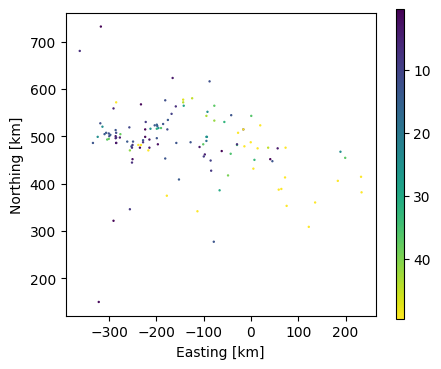

In [15]:
# The parameters in the associator class: n_picks=2,n_p_picks=1,n_s_picks=1,n_p_and_s_picks=1
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

# ax.scatter(events["x"], events["y"], c=events["z"])
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cb1 = fig.colorbar(ax.scatter(events["x"], events["y"], c=events["z"],s=0.5,cmap='viridis'), cax=cax)
cb1.ax.invert_yaxis()

In [16]:
catalog = pd.read_csv(f'../data/datasets_{region}/catalog_hypoinverse_{region}.csv',index_col=0)
len(catalog)

317

In [17]:
from datetime import datetime


stations = pd.read_csv(f"./stations_{region}.csv", sep="\t")
stations['net'] = stations['station'].apply(lambda x: x.split('.')[0])
stations['sta'] = stations['station'].apply(lambda x: x.split('.')[1])
stations['cha'] = stations['station'].apply(lambda x: x.split('.')[3])

picks = pd.read_csv(f'../data/datasets_{region}/picks_hypoinverse_{region}.csv', sep="\t")
events = pd.read_csv(f'../data/datasets_{region}/catalog_hypoinverse_{region}.csv', sep="\t")

events["match_id"] = events["event_index"]
picks["match_id"] = picks["event_index"]
events.sort_values(by="time", inplace=True, ignore_index=True)

out_file = open(f"../hypoInv/hypoInput_{region}.arc", "w")

events['time'] = pd.to_datetime(events['time'])

picks_by_event = picks.groupby("match_id").groups
for i in tqdm(range(len(events))):

    event = events.iloc[i]
    event_time = event["time"].strftime("%Y%m%d%H%M%S%f")[:-4]
    lat_degree = int(event["latitude"])
    lat_minute = (event["latitude"] - lat_degree) * 60 * 100
    south = "S" if lat_degree <= 0 else " "
    lng_degree = int(event["longitude"])
    lng_minute = (event["longitude"] - lng_degree) * 60 * 100
    east = "E" if lng_degree >= 0 else " "
    depth = event["depth_km"]
    if np.sum(picks[picks["event_index"] == events.iloc[i]['match_id']]['type'] == 'p') == 0:
        continue
    event_line = f"{event_time}{abs(lat_degree):2d}{south}{abs(lat_minute):4.0f}{abs(lng_degree):3d}{east}{abs(lng_minute):4.0f}{depth:5.0f}"
    out_file.write(event_line + "\n")

    picks_idx = picks_by_event[event["match_id"]]
    for j in picks_idx:
        pick = picks.iloc[j]
        station_code = pick['id']
        network_code = stations['net'][stations['sta'] == pick['id']].iloc[0]
        comp_code = ''
        channel_code = stations['cha'][stations['sta'] == pick['id']].iloc[0]
        phase_type = pick['type']
        
        # Check if 'prob' column exists
        if 'prob' in pick:
            phase_weight = min(max(int((1 - pick['prob']) / (1 - 0.3) * 4) - 1, 0), 3)
        else:
            phase_weight = 0  # Default value if 'prob' column is missing
        # 2011-01-02 02:11:06.849100+00:00
        # Assuming pick['timestamp'] has the format '2012-01-01 03:19:00.689664+00:00'
        try:
            pick_time = datetime.strptime(pick["timestamp"], "%Y-%m-%dT%H:%M:%S.%f")  # Handle timezone with %z
        except:
            pick_time = datetime.strptime(pick["timestamp"], "%Y-%m-%dT%H:%M:%S%z")  # Handle timezone with %z
        phase_time_minute = pick_time.strftime("%Y%m%d%H%M")  # Extract YYYYMMDDHHMM
        phase_time_second = pick_time.strftime("%S%f")[:-4]  # Extract seconds with first two digits of microseconds
        tmp_line = f"{station_code:<5}{network_code:<2} {comp_code:<1}{channel_code:<3}"
        if phase_type.upper() == 'P':
            pick_line = f"{tmp_line:<13} P {phase_weight:<1d}{phase_time_minute} {phase_time_second}"
        elif phase_type.upper() == 'S':
            pick_line = f"{tmp_line:<13}   4{phase_time_minute} {'':<12}{phase_time_second} S {phase_weight:<1d}"
        else:
            raise ValueError(f"Phase type error {phase_type}")
        out_file.write(pick_line + "\n")

    out_file.write("\n")
    if i > 1e5:
        break

out_file.close()

 20%|█▉        | 62/317 [00:00<00:00, 616.08it/s]

100%|██████████| 317/317 [00:00<00:00, 640.65it/s]
